In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
plt.style.use(["science","grid"])
def normalise(arr):
    arrmax = np.max(arr)
    arrmin = np.min(arr)
    
    arrnorm = (arr - arrmin) / (arrmax - arrmin)
    
    return arrnorm
def ticks_labels(nb_days):
    if 30%nb_days != 0:
        raise ValueError 
    else:
        vec = np.linspace(0,4320,int(30/nb_days)+1)
        labs = list()
        for i in range(int(30/nb_days)+1):
            labs.append("Day %s"%(i*nb_days))
        return vec,labs

my_palette = {}
my_palette['dark'] = ['midnightblue', 'chocolate', 'darkolivegreen']
my_palette['light'] = ['cornflowerblue','orange','yellowgreen']
my_palette['reds'] = []

In [17]:
data1 = pd.read_feather("./capacity/capacity30_beta0.0") # rerouting 30                        
data2 = pd.read_feather("./capacity/capacity30_beta1.0") # rerouting 30

input1 = pd.read_csv("./capacity/input_parameters_capacity30_beta0.0.csv")
input2 = pd.read_csv("./capacity/input_parameters_capacity30_beta1.0.csv")

# data2.o0 = data2.o0 + len(input1)

data = data2 #pd.concat([data1,data2]).reset_index()
input_vars = input2 #pd.concat([input1,input2]).reset_index()

In [18]:
q_sum = list()
n_facs = 12
for j in input_vars.index:
    tmp_sum = 0
    for i in range(n_facs):
        tmp_sum += ( np.sum(data[data.o0==j].iloc[:,i+4]))  
    
    q_sum.append(tmp_sum)    

uc_endvals_dict = {}
for i in ["unsatisfied consumption","policy type","variation","allfacs","fac5","distance"]:
    uc_endvals_dict[i] = list()
    
uc_endvals_dict["fac5"] = list()


for j in input_vars.index:
    uc_endvals_dict["unsatisfied consumption"].append(data.o1[data.o0==j].iloc[-1])
    uc_endvals_dict["distance"].append(data.o3[data.o0==j].iloc[-1])
    uc_endvals_dict["fac5"].append( np.sum(data[data.o0==j].iloc[:,9]))
    uc_endvals_dict["allfacs"].append( q_sum[j] )

    if input_vars.capacity_policy[j] > 0:
        uc_endvals_dict["policy type"].append(1)
        uc_endvals_dict["variation"].append(input_vars.capacity_policy[j])
    else:
        uc_endvals_dict["policy type"].append(0)
        uc_endvals_dict["variation"].append(0)    

uc_endvals_df = pd.DataFrame(uc_endvals_dict)
input_vars_filtered = pd.concat([input_vars,uc_endvals_df],axis=1)

/home/daan/miniconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 36.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-37-480ee7591937>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(np.linspace(0,40,9))


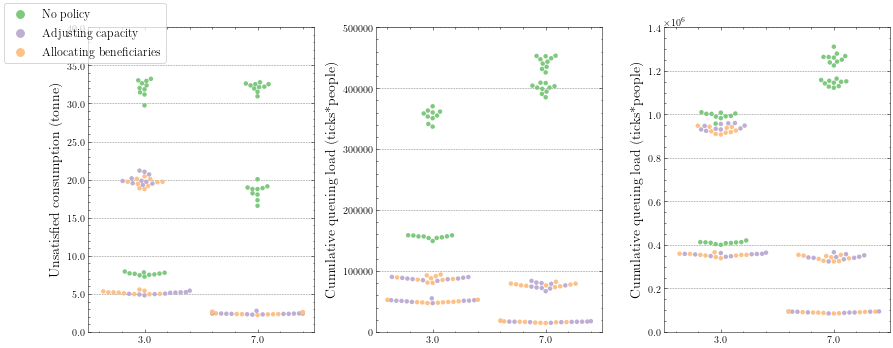

In [37]:
fig, ax = plt.subplots(1,3,figsize=(12.5,5))
# tmp = pd.concat([input_vars_filtered,pd.DataFrame({'x':np.ones(len(input_vars_filtered))})],axis=1)

gs = [[3.0,7.8],[7.0,6.0]]
tmp2 = input_vars_filtered[input_vars_filtered.gamma==3]
tmp2 = tmp2[tmp2.parallel_served_full==7.8]
tmp1 = input_vars_filtered[input_vars_filtered.gamma==7]
tmp1 = tmp1[tmp1.parallel_served_full==6.0]
tmp = pd.concat([tmp1,tmp2])

# sns.swarmplot(ax=ax[0] ,x='gamma',hue='variation', y="unsatisfied consumption", data=tmp,size=4.5)#palette=my_palette['dark'])
# sns.swarmplot(ax=ax[1] ,x='gamma',hue='variation', y="fac5", data=tmp,size=4.5)#palette=my_palette['dark'])
# sns.swarmplot(ax=ax[2] ,x='gamma',hue='variation', y="allfacs", data=tmp,size=4.5)#palette=my_palette['dark'])


ylims = [ [0,40e3],[0,500e3],[0,1.4e6]]
ylabels = ["Unsatisfied consumption (tonne)","Cumulative queuing load (ticks*people)","Cumulative queuing load (ticks*people)"]
strings = ["unsatisfied consumption","fac5","allfacs"]

for i in range(len(strings)):
    sns.swarmplot(ax=ax[i],x="gamma",y=strings[i],hue='variation',data=tmp,palette='Accent',size=4.5)
    ax[i].set_ylim(ylims[i])
#     ax[i].set_xticklabels(["bad perception","good perception"],fontsize=14)
    ax[i].set_ylabel(ylabels[i],fontsize=14)
    ax[i].set_xlabel(None)
ax[2].get_legend().remove()
ax[1].get_legend().remove()
handles = ax[i].get_legend_handles_labels()[0]
ax[0].legend(handles[:3], ["No policy","Adjusting capacity","Allocating beneficiaries"],loc='upper left',fontsize=12,bbox_to_anchor=(-0.4, 1.1),framealpha=0.75)
ax[0].set_yticklabels(np.linspace(0,40,9))
fig.tight_layout() 
plt.savefig("/home/daan/Desktop/capacity_otherkpis.png")

<AxesSubplot:xlabel='gamma', ylabel='fac5'>

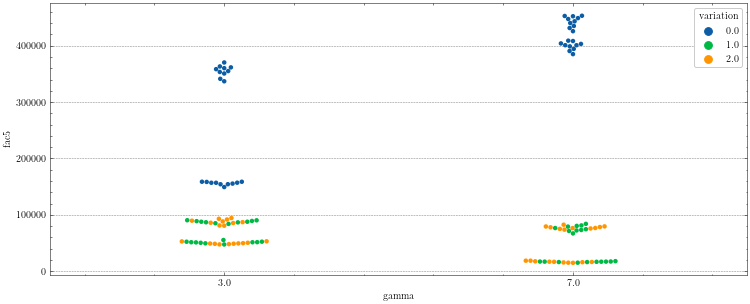

In [15]:
fig, ax = plt.subplots(1,1,figsize=(12.5,5))

sns.swarmplot(ax=ax ,x='gamma',hue='variation', y="fac5", data=tmp,size=4.5)#palette=my_palette['dark'])


# ax.set_xlabel(None)#r"Type of policy",fontsize=12)
# ax.set_xticklabels(["No social interaction\nLow visiting frequency",
#                    "No social interaction\nHigh visiting frequency",
#                    "High social interaction\nLow visiting frequency",
#                    "High social interaction\nHigh visiting frequency"],fontsize=14)

# ax.set_ylim([0,100e3])
# ax.set_yticklabels(np.linspace(0,100,6))
# ax.set_ylabel("Unsatisfied consumption (tonnes)",fontsize=14)

# ax.yaxis.grid(True) # Hide the horizontal gridlines
# ax.xaxis.grid(True) # Show the vertical gridlines

# handles = ax.get_legend_handles_labels()[0]

# labels = ["No policy","Active Q mngmnt","Undirected rerouting","Directed rerouting"]

# ax.legend(handles[:4],labels,loc='upper left',fontsize=12);
# ax.set_title("a) Scenario without social interaction between agents",fontsize=14);